## Importing Libraries & Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.models.signature import infer_signature
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load the dataset
df = pd.read_csv("C:/Users/Nil/Documents/GUVI PROJECT/Medical Insurance Predict ML/data/medical_insurance.csv")

In [3]:
# Top 5 data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [5]:
# Statistical information
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
# Check null values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
# Check duplicate data
df.duplicated().sum()

np.int64(1435)

Here 1435 rows are duplicate, so we remove these rows to maintain clean data

In [8]:
# Drop duplicated data
df = df.drop_duplicates()

In [9]:
# Unique values in categorical columns
columns = ['sex', 'smoker', 'region']

for col in columns:
    print(df[col].value_counts())

sex
male      675
female    662
Name: count, dtype: int64
smoker
no     1063
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


In [10]:
# Encode the categorical columns
df['num_sex'] = df['sex'].map({'male':1, 'female':0})
df['num_smoker'] = df['smoker'].map({'yes':1, 'no':0})
df['num_region'] = df['region'].map({'northeast':0, 'northwest':1, 'southwest':2, 'southeast':3})

# EDA ( Exploratory Data Analysis)

### Univariate Analysis (Single Variable)

<Axes: xlabel='charges', ylabel='Count'>

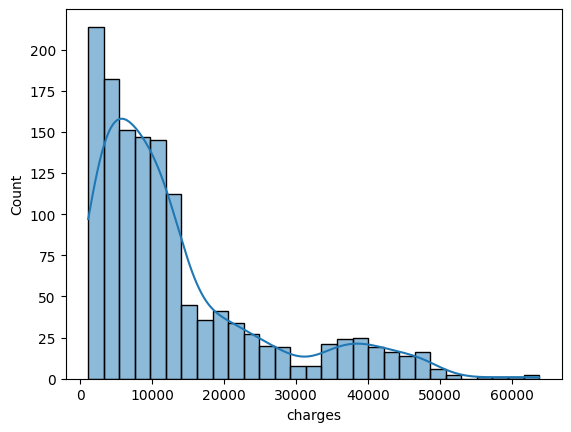

In [11]:
# Distribution plot of target(charges) column
sns.histplot(df['charges'],kde = True)

- The distribution plot indicates the data is positively skewed (right long tail).
- So, there are lot of outliers in the target columns.
- Log transformation should be used to make it normal distribution.

<Axes: xlabel='age', ylabel='Count'>

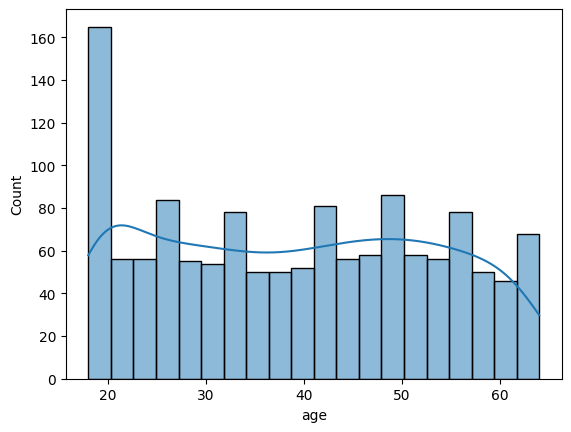

In [12]:
# Distribution plot of age column
sns.histplot(df['age'],bins= 20, kde = True)

- The age distribution is relatively uniform, with most policyholders spread across the adult age range.
- There are no significant gaps or spikes, indicating a balanced representation of different age groups.

<Axes: xlabel='smoker', ylabel='count'>

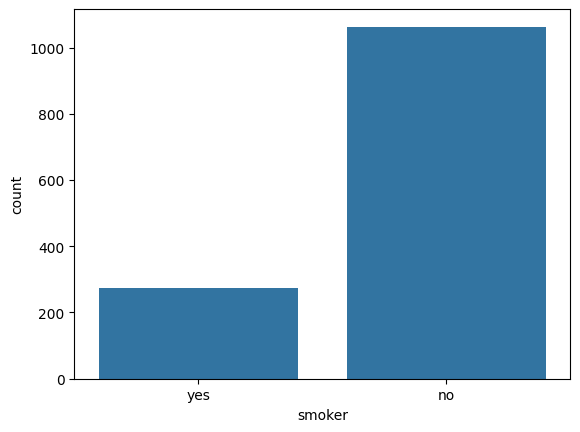

In [13]:
# Number of smoker and non-smoker
sns.countplot(x= 'smoker', data= df)

In [14]:
# Average BMI
df['bmi'].mean()

np.float64(30.66345175766642)

<Axes: xlabel='region', ylabel='count'>

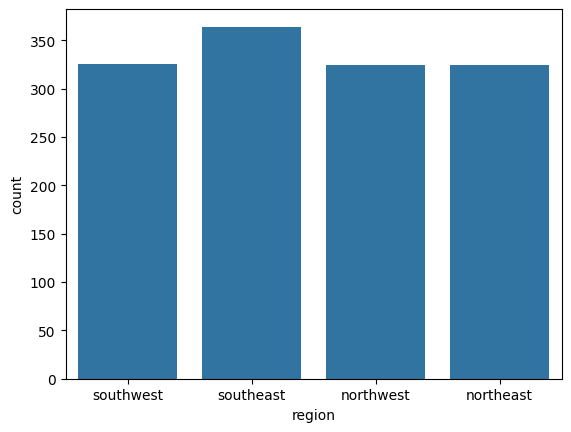

In [15]:
# Most policyholder by region 
sns.countplot(x= 'region', data= df)

### Bivariate Analysis (Two Variables)

<Axes: xlabel='age', ylabel='charges'>

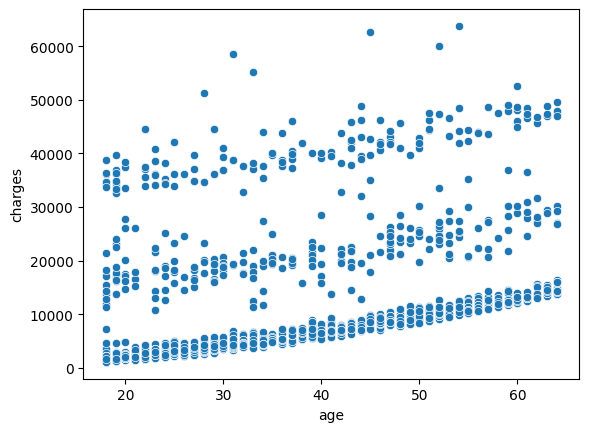

In [16]:
# Charges vs Age
sns.scatterplot(x = 'age',y = 'charges',data = df)

- As age increases, insurance charges tend to increase as well which indicates a positive relationship between age and charges.
- The spread of charges also widens with age, indicating greater variability in charges for older individuals.
- This suggests that age is an important factor in determining insurance costs.

In [17]:
# Average charges (smokers and non-smoker)
df.groupby('smoker')['charges'].mean()

smoker
no      8440.660307
yes    32050.231832
Name: charges, dtype: float64

Since, there are less no of smoker compare to non-smoker, thats why the average for smoker is far greater than the averge for non-smoker.

<Axes: xlabel='bmi', ylabel='charges'>

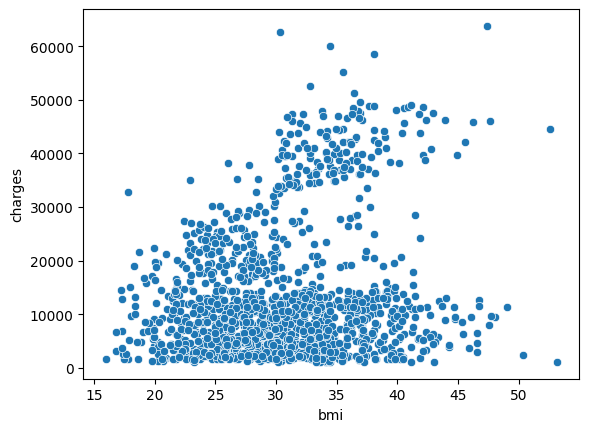

In [18]:
# BMI vs Charges
sns.scatterplot(x= 'bmi',y = 'charges',data = df)

- The scatterplot shows a weak positive relationship between BMI and insurance charges.
- Individuals with higher BMI tend to have slightly higher charges, but the relationship is not very strong.
- There is a wide spread of charges for each BMI value, indicating that other factors also play a significant role in determining charges.

In [19]:
# Male vs Female (Who pays more) - avg charges
df.groupby('sex')['charges'].mean()

sex
female    12569.578844
male      13974.998864
Name: charges, dtype: float64

Mens pays more on average charges.

In [20]:
# Correlation between children and charges
df[['children','charges']].corr()

,children,charges
children,1.000000,0.067389
charges,0.067389,1.000000


- very week coorelation between the children and charges column.

### Multivariate Analysis (More than Two Variables)

<Axes: xlabel='age', ylabel='charges'>

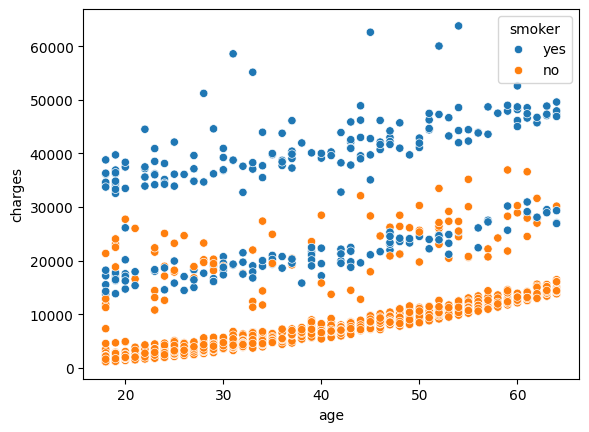

In [21]:
# (Smoker & Age) vs Charges
sns.scatterplot(x = 'age', y = 'charges', data = df, hue = 'smoker')

- This visualization effectively demonstrates that both age and smoking status are important factors in determining insurance charges, with smoking having a particularly strong impact on increasing insurance costs regardless of age.

<Axes: xlabel='region', ylabel='charges'>

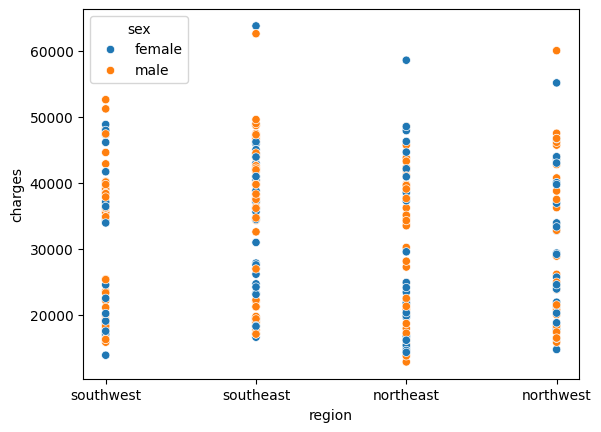

In [22]:
# (Region & Sex) vs Charges for Smoker only
df_smoker = df[df['smoker']=='yes']

sns.scatterplot(x = 'region', y = 'charges', data = df_smoker, hue = 'sex')

- Regional variations in insurance charges for smokers
- Gender-based differences in charges within the smoking population
- The spread of charges in each region showing pricing variability
- Potential clustering that might indicate specific pricing tiers or risk categories in different regions

In [23]:
# Age grouping
def age_group(age):
    if 18<=age<=30 :
        return '18-30'
    elif 31<=age<=45 :
        return '31-45'
    else:
        return '46-64'

df['age_group'] = df['age'].apply(age_group)

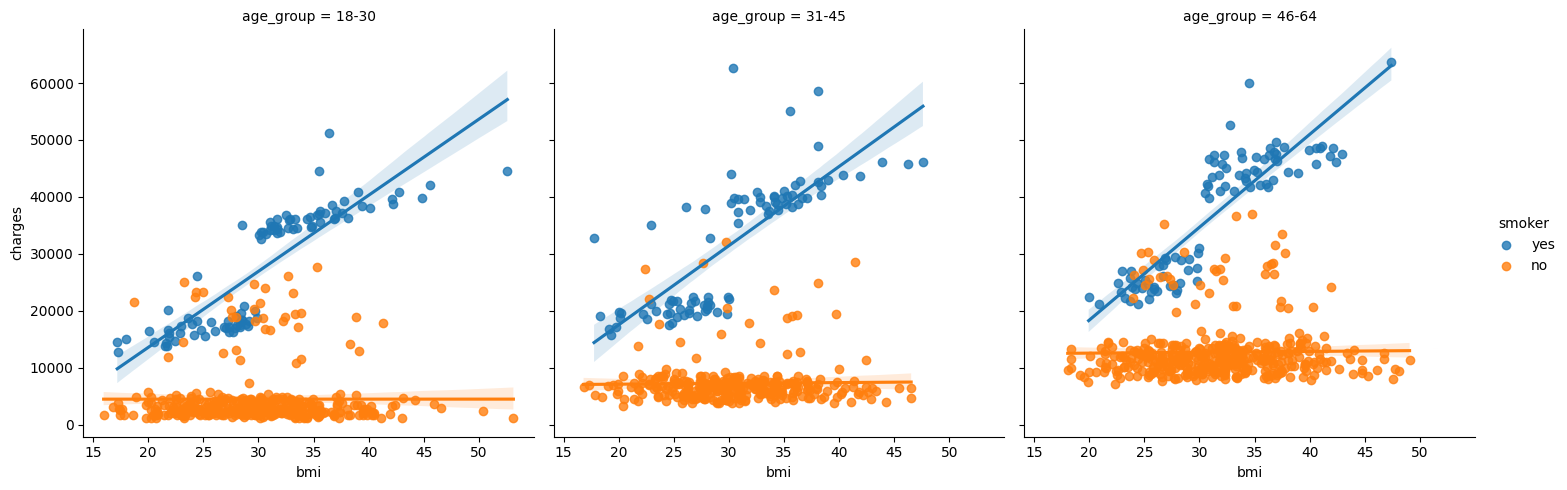

In [24]:
# (Age & Bmi & Smoker) vs Charges
sns.lmplot(data= df,x= 'bmi', y= 'charges',hue= 'smoker',col= 'age_group')

- Each age group (18-30, 31-45, 46-64) shows distinct patterns in how BMI relates to charges
- Smokers consistently have higher charges across all BMI levels and age groups
- The impact of BMI on charges is more pronounced (steeper slope) for smokers
- The combination of high BMI and smoking has a compounding effect on insurance charges

In [25]:
# Obese smokers vs non-obese smokers
group1 = df[(df['bmi']>30) &(df['smoker']=='yes')]['charges'].mean()
group2 = df[(df['bmi']<30) &(df['smoker']=='yes')]['charges'].mean()

print(f"Average charges for smokers with BMI > 30 =  {group1:.3f}")
print(f"Average charges for smokers with BMI < 30 =  {group2:.3f}")

Average charges for smokers with BMI > 30 =  41692.809
Average charges for smokers with BMI < 30 =  21363.217


- Yes, obese smokers (BMI > 30) pay significantly higher than non-obese non-smokers.

## Outliers

<Axes: ylabel='charges'>

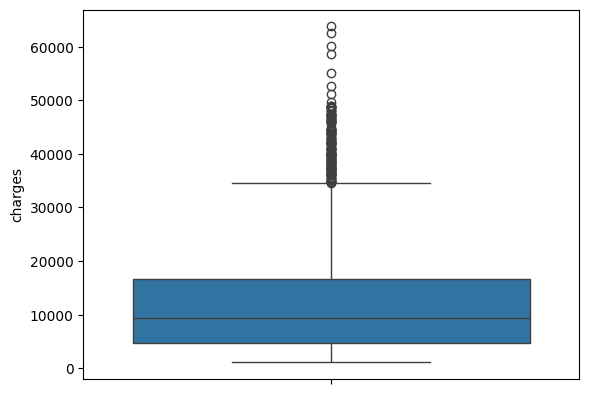

In [26]:
# Boxplot to see outliers
sns.boxplot(df['charges'])

- Almost after 35000, there are many outliers.

In [27]:
# Top 5 paying charges 
df.sort_values(by = 'charges',ascending=False).head()

,age,sex,bmi,children,smoker,region,charges,num_sex,num_smoker,num_region,age_group
543,54,female,47.410,0,yes,southeast,63770.42801,0,1,3,46-64
1300,45,male,30.360,0,yes,southeast,62592.87309,1,1,3,31-45
1230,52,male,34.485,3,yes,northwest,60021.39897,1,1,1,46-64
577,31,female,38.095,1,yes,northeast,58571.07448,0,1,0,31-45
819,33,female,35.530,0,yes,northwest,55135.40209,0,1,1,31-45


<Axes: ylabel='bmi'>

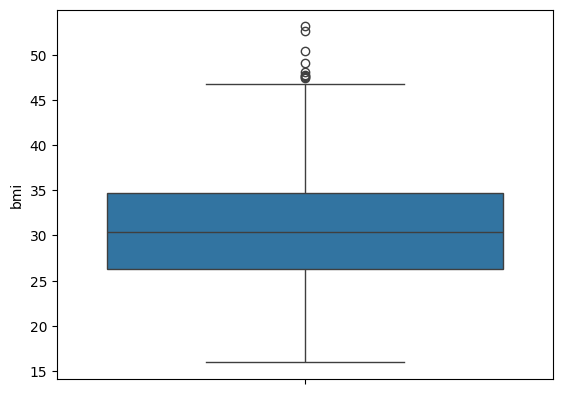

In [28]:
# Outliers in BMI
sns.boxplot(df['bmi'])

- The boxplot above shows that there are a few extreme BMI values (outliers) in the dataset.
- These outliers can skew model predictions, especially for algorithms sensitive to extreme values (like linear regression).

## Correlation

<Axes: >

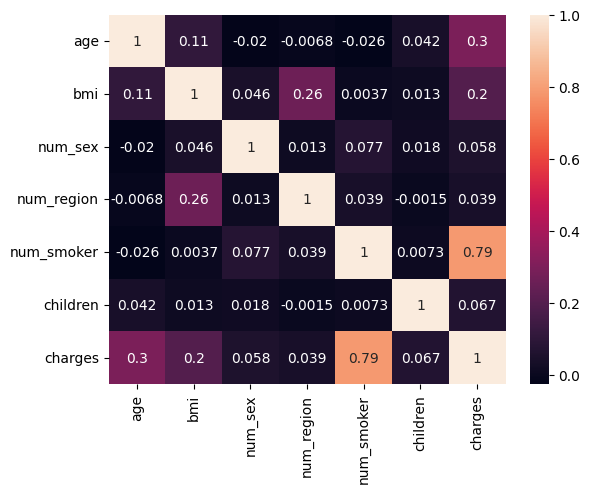

In [29]:
# Correlation between Age, BMI, Children & Charges
sns.heatmap(df[['age','bmi','num_sex','num_region','num_smoker','children','charges']].corr(), annot=True)

- Age and charges have a moderate positive correlation, meaning older individuals tend to have higher insurance charges.
- BMI and charges show a weak to moderate positive correlation, so higher BMI may slightly increase charges.
- The number of children, sex, and region have little to no correlation with charges, indicating they are not strong predictors.
- Smoker status has a strong positive correlation with charges, confirming that being a smoker greatly increases insurance costs.

## Feature Engineering & Data Preparing

In [30]:
# Interaction term
df['bmi_smoker'] = df['bmi'] * df['num_smoker']

In [31]:
# Preparing data
X = df[['age', 'bmi', 'children', 'num_smoker', 'bmi_smoker']]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 3)

In [32]:
# Scaling the input features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (1069, 5)
Test data shape:  (268, 5)


## Model with MLFlow

In [34]:
# Set tracking URI & Experiment

mlflow.set_tracking_uri("file:///C:/Users/Nil/Documents/GUVI PROJECT/Medical Insurance Predict ML/mlruns")
mlflow.set_experiment("Medical_Insurance")

def build_model(name,model):
    with mlflow.start_run(run_name = name):
    
        # Train and Predict
        model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
    
        # Metrics
        mae_train = mean_absolute_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        r2_train = r2_score(y_train, y_train_pred)

        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2_test = r2_score(y_test, y_test_pred)
        
        print(f"\n-----{name}-----")
        print(f"Train(MAE): {mae_train:.3f} & Test(MAE): {mae_test:.3f}")
        print(f" Train(RMSE): {rmse_train:.3f} & Test(RMSE): {rmse_test:.3f}")
        print(f" Train(R2): {r2_train:.3f} & Test(R2): {r2_test:.3f}")

        # Log to MLflow
        mlflow.log_param("model_name", name)
        mlflow.log_metrics({
            "MAE": mae_test,
            "RMSE": rmse_test,
            "R2": r2_test
        })
        
        signature = infer_signature(X_test, y_test_pred)
    
        if isinstance(model, XGBRegressor):
            mlflow.xgboost.log_model(model, name= "model", signature=signature)
        else:
            mlflow.sklearn.log_model(model, name= "model", signature=signature)

d:\Python\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/12 22:53:49 INFO mlflow.tracking.fluent: Experiment with name 'Medical_Insurance' does not exist. Creating a new experiment.


## Model Run

In [35]:
models = {'LinearRegression' : LinearRegression(),
          'Ridge' : Ridge(),
          'RandomForestRegressor' : RandomForestRegressor(random_state= 3),
          'GradientBoostingRegressor' : GradientBoostingRegressor(random_state= 3),
          'XGBRegressor' : XGBRegressor(random_state= 3)
         }

In [36]:
for name,model in models.items():
    build_model(name,model)


-----LinearRegression-----
Train(MAE): 2953.185 & Test(MAE): 2804.537
 Train(RMSE): 4937.132 & Test(RMSE): 4551.157
 Train(R2): 0.833 & Test(R2): 0.860

-----Ridge-----
Train(MAE): 2955.770 & Test(MAE): 2813.219
 Train(RMSE): 4938.432 & Test(RMSE): 4561.261
 Train(R2): 0.833 & Test(R2): 0.859

-----RandomForestRegressor-----
Train(MAE): 1028.826 & Test(MAE): 2600.968
 Train(RMSE): 1891.873 & Test(RMSE): 4830.166
 Train(R2): 0.976 & Test(R2): 0.842

-----GradientBoostingRegressor-----
Train(MAE): 2093.378 & Test(MAE): 2342.220
 Train(RMSE): 3794.202 & Test(RMSE): 4296.095
 Train(R2): 0.902 & Test(R2): 0.875

-----XGBRegressor-----
Train(MAE): 592.209 & Test(MAE): 2684.742
 Train(RMSE): 1077.694 & Test(RMSE): 4977.932
 Train(R2): 0.992 & Test(R2): 0.832


- Gradient Boosting achieved the highest test R² of 0.875, with minimal train–test gap, indicating good generalization.
- Random Forest and XGBoost performed similarly, i.e, overfitting.
- Linear and Ridge provided strong baselines confirming mostly linear feature relationships.

Overall, Gradient Boosting gave the best performance–interpretability tradeoff.

## Hyperparameter Tuning

In [37]:
# Parameters for Hyperparameter Tuning
param = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
}

In [38]:
model = GradientBoostingRegressor(random_state= 3)
random_search = RandomizedSearchCV(estimator=model, param_distributions= param, n_iter= 25, cv=5, scoring='r2', verbose=1, n_jobs=-1)

random_search.fit(X_train,y_train)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best R² Score: {random_search.best_score_}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.01}
Best R² Score: 0.8470510982804624


## Final Model

In [39]:
name = 'GradientBoost_tuned'
final_model = GradientBoostingRegressor(random_state= 3, **random_search.best_params_)

build_model(name, final_model)


-----GradientBoost_tuned-----
Train(MAE): 2525.938 & Test(MAE): 2405.686
 Train(RMSE): 4301.664 & Test(RMSE): 4138.416
 Train(R2): 0.873 & Test(R2): 0.884


- GradientBoost performance with R² ≈ 0.884, explaining about 88% of the variation in medical charges.

- The small gap between train and test performance (<1%) indicates the model generalizes very well and is not overfitting.

- The average absolute error (MAE) of around ₹2,400 means the model predicts insurance costs with a high level of precision relative to the dataset range.

In [40]:
# Save the scaler and final model
import joblib

joblib.dump(scaler, "scaler.pkl")
joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']